In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn 

from IPython.display import clear_output

%matplotlib inline

## Домашнее задание: 

**1). Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции $y = \frac{sin(x)}{x} - \frac{x}{10}$. При выполненинии данного задания структура GAN остается той же, но Вам нужно:**
 - **Сгенерировать настоящие данные**
 - **Изменить архитектуру дискриминатора и генератора**
 - **Без графиков домашку не принимаю**

Сделал на основе ноубука с вебинара и этого примера [[link](https://proglib.io/p/generativno-sostyazatelnaya-neyroset-vasha-pervaya-gan-model-na-pytorch-2020-08-11)]

In [2]:
def func_y(x):
    if x == 0:
        return 1
    return np.sin(x)/x - x/10
    
func_y = np.vectorize(func_y)

In [3]:
lr = 0.001
n_epochs = 2010
batch_size = 32
seed = 2020

In [4]:
torch.manual_seed(seed)

train_data_length = 1024
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.randint(-15, 15, (train_data_length, ))
train_data[:, 1] = torch.FloatTensor(func_y(train_data[:, 0]))
#train_labels = torch.zeros(train_data_length)
train_set = [train_data[i] for i in range(train_data_length)]
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True)

In [5]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) 

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            CustomLinearLayer(256, 128),
            nn.ReLU(),            
            nn.Dropout(0.3),
            CustomLinearLayer(128, 64),
            nn.ReLU(),            
            nn.Dropout(0.3),
            CustomLinearLayer(64, 1),
            nn.Sigmoid(),
        )
  
    def forward(self, inputs):
        validity = self.model(inputs)
        return validity


discriminator = Discriminator()

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat):
            layers = [nn.Linear(in_feat, out_feat)]
            layers.append(nn.ReLU(inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(2, 16),
            *block(16, 32),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        output = self.model(x)
        return output


generator = Generator()

In [8]:
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr)
adversarial_loss = nn.BCELoss()

[Epoch: 2000] Loss D.: 0.5930 Loss G.: 1.1844


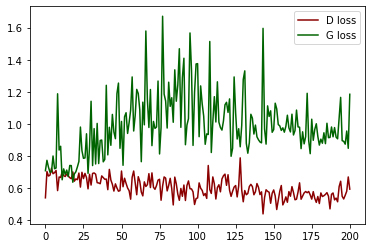

In [9]:
torch.manual_seed(seed)

d_loss_history, g_loss_history = [], []
xs, ys = [], []
for epoch in range(n_epochs):
    for n, real_data in enumerate(train_loader, 1):
        # Данные для обучения дискриминатора
        valid = torch.ones((batch_size, 1))
        fake = torch.zeros((batch_size, 1))

        z = torch.randn((batch_size, 2))
        gen_data = generator(z)

        all_data = torch.cat((real_data, gen_data))
        all_labels = torch.cat((valid, fake))

        # Обучение дискриминатора
        discriminator.zero_grad()
        all_pred = discriminator(all_data)
        d_loss = adversarial_loss(all_pred, all_labels)
        d_loss.backward()
        optimizer_D.step()

        # Данные для обучения генератора
        z = torch.randn((batch_size, 2))

        # Обучение генератора
        generator.zero_grad()
        gen_data = generator(z)
        validity = discriminator(gen_data)
        g_loss = adversarial_loss(validity, valid)
        g_loss.backward()
        optimizer_G.step()

        # Выводим значения функций потерь
        if epoch % 10 == 0 and n == batch_size:

            clear_output(wait=True)
            print(f"[Epoch: {epoch}] Loss D.: {d_loss:.4f} Loss G.: {g_loss:.4f}")

            gen_data = gen_data.detach()
            xs.append(gen_data[:, 0].tolist())
            ys.append(gen_data[:, 1].tolist())

            d_loss_history.append(d_loss.item())
            g_loss_history.append(g_loss.item())
            plt.plot(d_loss_history, label='D loss', c='darkred')
            plt.plot(g_loss_history, label='G loss', c='darkgreen')
            plt.legend(loc='upper right')
            plt.show()      


Сгенерированные данные - все батчи и самый последний:

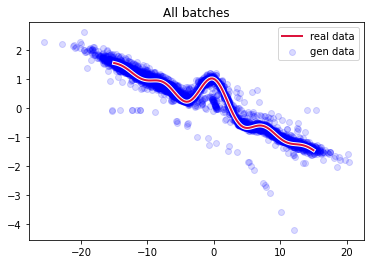

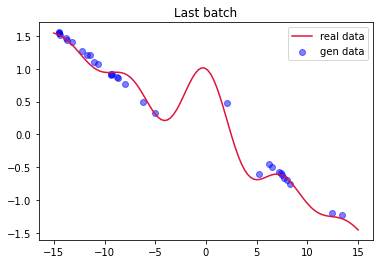

In [10]:
x = np.linspace(-15, 15, 100)
plt.plot(x, func_y(x), c='w', lw=4)
plt.plot(x, func_y(x), c='crimson', label='real data', lw=2)
plt.scatter(xs, ys, c='b', alpha=0.15, label='gen data')
plt.title('All batches')
plt.legend(loc='best')
plt.show()

plt.plot(x, func_y(x), c='crimson', label='real data')
plt.scatter(xs[-1], ys[-1], c='b', alpha=0.5, label='gen data')
plt.title('Last batch')
plt.legend(loc='best')
plt.show()

**2). Изменить используемые модели генератора и дискриминатора, с помощью сверточных слоев. Идея: https://arxiv.org/abs/1511.06434 Датасет можно использовать так же MNIST.**